# Project 2


# Movie Genre Classification

Classify a movie genre based on its plot.

<img src="moviegenre.png"
     style="float: left; margin-right: 10px;" />




https://www.kaggle.com/c/miia4200-20191-p2-moviegenreclassification/overview


### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 20% API
- 30% Create a solution using with a Machine Learning algorithm - Presentation (5 slides)
- 50% Performance in the Kaggle competition (Normalized acording to class performance in the private leaderboard)


### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Sample Submission

In [9]:
!pip install category_encoders

In [1]:
import pandas as pd
import os
import numpy as np
import category_encoders as ce
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import xgboost as xgb
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.externals import joblib
import nltk
nltk.download('wordnet')
import re  

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
dataTraining = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [3]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


### Create y

In [5]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])
print(y_genres.shape)
y_genres

(7895, 24)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

p_Action         1303
p_Adventure      1024
p_Animation       260
p_Biography       373
p_Comedy         3046
p_Crime          1447
p_Documentary     419
p_Drama          3965
p_Family          682
p_Fantasy         707
p_Film-Noir       168
p_History         273
p_Horror          954
p_Music           341
p_Musical         271
p_Mystery         759
p_News              7
p_Romance        1892
p_Sci-Fi          723
p_Short            92
p_Sport           261
p_Thriller       2024
p_War             348
p_Western         237
dtype: int64

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


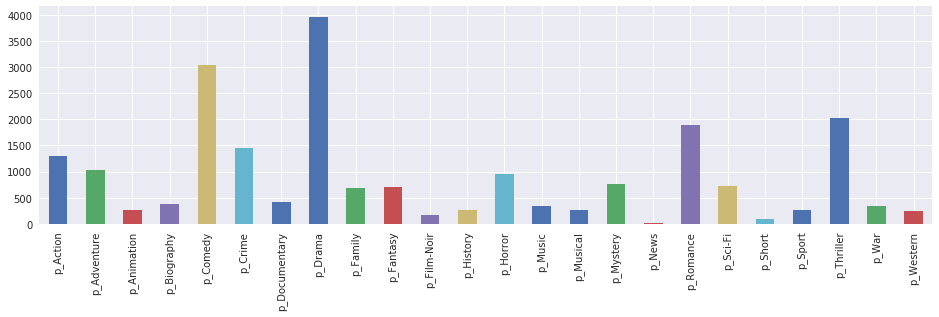

In [6]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

#train_DFY = pd.concat([train_DFY, dataTraining[['year']].reset_index()], axis=1)
# ploter = train_DFY.groupby("year").sum().iloc[:,:24]
# ploter.head()

train_DFY = pd.DataFrame(y_genres, columns=cols)
pd.Series(train_DFY.sum().plot(kind = "bar",figsize=(16,4),rot = 0))
plt.xticks(rotation=90)
train_DFY.sum()

# Preprocessing
### Function for clean plot and title


In [9]:
# This function transform the text in order get ready data, remove stop words, stimming, Lemmatisation and n_grams
# This function is call by the count vectorizer
def text_clean(text, remove_stop_words=True):
    wordnet_lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer('english')
    document = text
    
    # Remove all the special characters
    document = re.sub(r'\W', ' ', document)

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    #Removing punctuation
    document = re.sub(r'[^\w\s]', '', document)

    #LowerCase    
    document = document.lower()
    
    #Split document word a word
    words_document = text.split()
    
    #Remove clean_words
    words_document = [word for word in words_document if word not in waste_words]
    #Remove stop words
    if remove_stop_words:
        words_document = [word for word in words_document if word not in custom_stopwords]
    
    #stimming
    words_document = [stemmer.stem(word) for word in words_document]
    
    #Lemmatisation
    words_document = [wordnet_lemmatizer.lemmatize(word) for word in words_document]
    words_document = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words_document]
           
    return ' '.join(words_document)


# The next lines are just for test the function
var = dataTraining.iloc[1,2]
#var = dataTraining.iloc[1,2] + " "+ dataTraining.iloc[1,1] + " "+str(dataTraining.iloc[1,0])
print(var)
text_clean(var, remove_stop_words=True)

a serial killer decides to teach the secrets of his satisfying career to a video store clerk .


'serial killer decid teach secret satisfi career video store clerk'

In [10]:
#Pre - process plot texts
plot_clean = []
for text in dataTraining["plot"]:
    plot_clean.append(text_clean(text))
    
#Pre - process title texts
title_clean = []
for text in dataTraining["title"]:
    title_clean.append(text_clean(text, remove_stop_words=False))

# Build the features
### Create count vectorizer function

In [11]:
YearBinaryEnco = ce.BinaryEncoder()
tfidf_plot = TfidfVectorizer()
tfidf_title = TfidfVectorizer()
vect_plot = CountVectorizer()
vect_title = CountVectorizer()

def create_XFeatures(plot_clean, title_clean, year, indexer, useCount=True, fit=True): 
    
    #year BinaryEncoder
    dataTraining.year = dataTraining.year.astype(str)
    if fit: YearBinaryEnco.fit(year)
    YearBinary = YearBinaryEnco.transform(year)
    #print("YearBinary: " + str(YearBinary.shape))
    joblib.dump(YearBinaryEnco, 'YearBinaryEnco.pkl', compress=3)
    

    #TfidfVectorizer plot
    if fit: tfidf_plot.fit(plot_clean)
    plot_tfidf_dtm = tfidf_plot.transform(plot_clean)
    print("plot_tfidf_dtm: " + str(plot_tfidf_dtm.shape))
    plot_feat_tfidf = pd.DataFrame(plot_tfidf_dtm.toarray(), columns=tfidf_plot.get_feature_names(), index=indexer)
    #print(plot_feat_tfidf.head())
    joblib.dump(tfidf_plot, 'tfidf_plot.pkl', compress=3)
    
    #TfidfVectorizer title
    if fit: tfidf_title.fit(title_clean)
    title_tfidf_dtm = tfidf_title.transform(title_clean)
    print("title_tfidf_dtm: " + str(title_tfidf_dtm.shape))
    title_feat_tfidf = pd.DataFrame(title_tfidf_dtm.toarray(), columns=tfidf_title.get_feature_names(), index=indexer)
    #print(title_feat_tfidf.head())
    joblib.dump(tfidf_title, 'tfidf_title.pkl', compress=3)
    
    if useCount:
        #CountVectorizer plot
        if fit: vect_plot.fit(plot_clean)
        plot_dtm = vect_plot.transform(plot_clean)
        print("plot_dtm: " + str(plot_dtm.shape))
        plot_features = pd.DataFrame(plot_dtm.toarray(), columns=vect_plot.get_feature_names(), index=indexer)
        #print(plot_features.head())
        
        #CountVectorizer title
        if fit: vect_title.fit(title_clean)
        title_dtm = vect_title.transform(title_clean)
        print("title_dtm: " + str(title_dtm.shape))
        title_features = pd.DataFrame(title_dtm.toarray(), columns=vect_title.get_feature_names(), index=indexer)
        #print(title_features.head())
        
        #concat all vectors
        return pd.concat([plot_feat_tfidf.add_suffix('_1'), 
                          title_feat_tfidf.add_suffix('_2'), 
                          plot_features.add_suffix('_3'), 
                          title_features.add_suffix('_4'),
                          YearBinary], axis=1)
        
    return pd.concat([plot_feat_tfidf.add_suffix('_1'), 
                      title_feat_tfidf.add_suffix('_2'), 
                      YearBinary], axis=1) 

### Set the vectorizer functión parameters and run 

In [35]:
#TD-IDF Vectorizer
tfidf_plot = TfidfVectorizer(ngram_range=(1, 10), max_features=7000,  min_df=12, max_df=0.9)
tfidf_title = TfidfVectorizer(ngram_range=(1, 4), max_features=7000, min_df=2, max_df=0.9)
#CountVectorizer
vect_plot = CountVectorizer(ngram_range=(1, 10), max_features=7000,  min_df=12, max_df=0.9)
vect_title = CountVectorizer(ngram_range=(1, 4), max_features=7000,  min_df=2, max_df=0.9)
#Year Binary encode
YearBinaryEnco = ce.BinaryEncoder()

#Fit the vectorizers and run with the clean data
X_features = create_XFeatures(plot_clean, title_clean, dataTraining[["year"]], dataTraining.index, True, True)
print(X_features.shape)
#X_features.head()

# YearBinary: (7895, 8)
# plot_tfidf_dtm: (7895, 5297)
# title_tfidf_dtm: (7895, 4310)
# plot_dtm: (7895, 5297)
# title_dtm: (7895, 4310)
# (7895, 19222)

plot_tfidf_dtm: (7895, 5297)
title_tfidf_dtm: (7895, 4310)
plot_dtm: (7895, 5297)
title_dtm: (7895, 4310)
(7895, 19222)


# Split train and test

In [36]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_features, y_genres, test_size=0.3, random_state=42)
X_train.shape

(5526, 19222)

p_Action          916
p_Adventure       716
p_Animation       174
p_Biography       250
p_Comedy         2108
p_Crime          1020
p_Documentary     305
p_Drama          2787
p_Family          451
p_Fantasy         496
p_Film-Noir       114
p_History         203
p_Horror          688
p_Music           230
p_Musical         185
p_Mystery         537
p_News              4
p_Romance        1310
p_Sci-Fi          490
p_Short            65
p_Sport           180
p_Thriller       1426
p_War             252
p_Western         158
dtype: int64


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


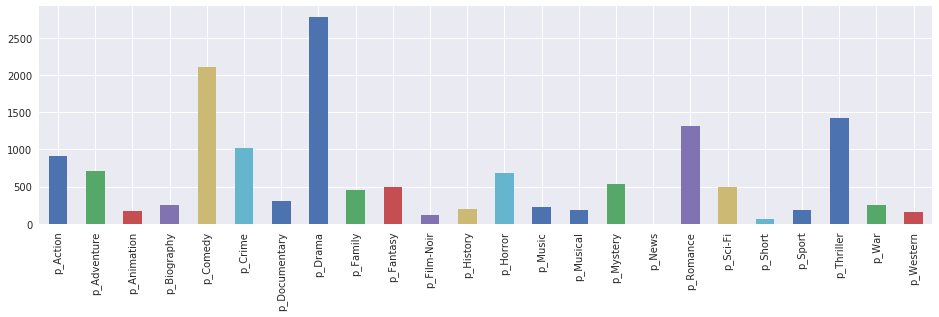

In [37]:
train_count_category = pd.DataFrame(y_train_genres, columns=cols, index=X_train.index)
pd.Series(train_count_category.sum().plot(kind = "bar",figsize=(16,4),rot = 0))
plt.xticks(rotation=90)
print(train_count_category.sum())

## Balancing clases
less than 800 rows oversampling to 800

In [38]:
def overSampleData (X_features, y_categories ):    
    overSampled_X = X_features
    train_count_category = pd.DataFrame(y_categories, columns=cols, index=X_train.index)
    overSampled_Y = train_count_category
    for i in range(1,24):
        if overSampled_Y.iloc[:,i].sum() < 800:
            #print("i=" + str(i) + " Cant: " + str(train_count_category.iloc[:,i].sum()))
            OverSampleIds = np.random.choice(X_train[train_count_category.iloc[:,i] == 1].index, 800)
            #print(dataTraining.loc[OverSampleIds].head())
            overSampled_X = pd.concat([overSampled_X, X_train.loc[OverSampleIds]], axis=0)
            overSampled_Y = pd.concat([overSampled_Y, train_count_category.loc[OverSampleIds]], axis=0)
            #print(overSampledDF.shape)
    return overSampled_X, overSampled_Y

overSampled_X, overSampled_Y = overSampleData(X_train, y_train_genres )     
overSampled_X.shape

(15926, 19222)

p_Action         2192
p_Adventure      3021
p_Animation      1573
p_Biography      2221
p_Comedy         4964
p_Crime          2354
p_Documentary    2644
p_Drama          7026
p_Family         2177
p_Fantasy        1515
p_Film-Noir       936
p_History        1936
p_Horror         1129
p_Music          1532
p_Musical        1375
p_Mystery        1036
p_News            830
p_Romance        3111
p_Sci-Fi         1709
p_Short          1038
p_Sport          1182
p_Thriller       3007
p_War             875
p_Western        1169
dtype: int64


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


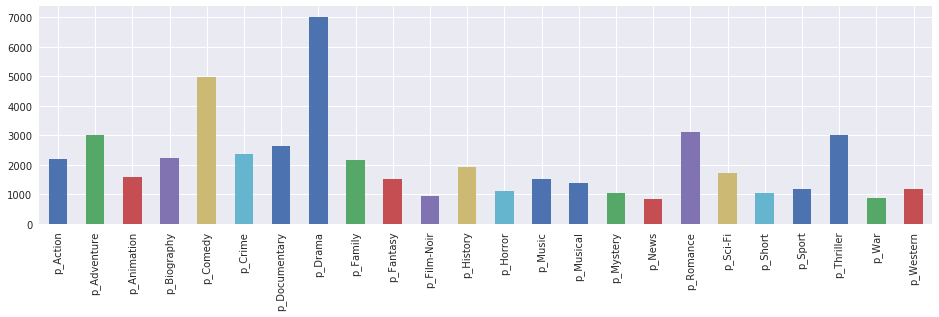

In [39]:
pd.Series(overSampled_Y.sum().plot(kind = "bar",figsize=(16,4),rot = 0))
plt.xticks(rotation=90)
print (overSampled_Y.sum())

In [18]:
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
%env JOBLIB_TEMP_FOLDER=/tmp
param_grid   = {"n_estimators": range(700,800,100), 
              "max_features": range(20,150,10), 
              "max_depth": range(10,50,10)}
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(overSampled_X, overSampled_Y)
grid_search.best_params_

env: JOBLIB_TEMP_FOLDER=/tmp
Fitting 3 folds for each of 52 candidates, totalling 156 fits
[CV] max_features=20, max_depth=10, n_estimators=700 .................
[CV] max_features=20, max_depth=10, n_estimators=700 .................
[CV] max_features=20, max_depth=10, n_estimators=700 .................
[CV] max_features=30, max_depth=10, n_estimators=700 .................
[CV] max_features=30, max_depth=10, n_estimators=700 .................
[CV] max_features=30, max_depth=10, n_estimators=700 .................
[CV] max_features=40, max_depth=10, n_estimators=700 .................
[CV] max_features=40, max_depth=10, n_estimators=700 .................
[CV] max_features=40, max_depth=10, n_estimators=700 .................
[CV] max_features=50, max_depth=10, n_estimators=700 .................
[CV] max_features=50, max_depth=10, n_estimators=700 .................
[CV] max_features=50, max_depth=10, n_estimators=700 .................
[CV] max_features=60, max_depth=10, n_estimators=700 ....

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min


[CV] max_features=100, max_depth=10, n_estimators=700 ................
[CV] .. max_features=50, max_depth=10, n_estimators=700, total= 1.5min
[CV] max_features=100, max_depth=10, n_estimators=700 ................
[CV] .. max_features=50, max_depth=10, n_estimators=700, total= 1.6min
[CV] max_features=100, max_depth=10, n_estimators=700 ................
[CV] .. max_features=50, max_depth=10, n_estimators=700, total= 1.6min
[CV] max_features=110, max_depth=10, n_estimators=700 ................
[CV] .. max_features=60, max_depth=10, n_estimators=700, total= 1.6min
[CV] max_features=110, max_depth=10, n_estimators=700 ................
[CV] .. max_features=60, max_depth=10, n_estimators=700, total= 1.7min
[CV] max_features=110, max_depth=10, n_estimators=700 ................
[CV] .. max_features=60, max_depth=10, n_estimators=700, total= 1.8min
[CV] max_features=120, max_depth=10, n_estimators=700 ................
[CV] .. max_features=70, max_depth=10, n_estimators=700, total= 1.7min
[CV] m

[CV] max_features=30, max_depth=30, n_estimators=700 .................
[CV] . max_features=110, max_depth=20, n_estimators=700, total= 3.1min
[CV] max_features=30, max_depth=30, n_estimators=700 .................
[CV] . max_features=120, max_depth=20, n_estimators=700, total= 3.1min
[CV] max_features=40, max_depth=30, n_estimators=700 .................
[CV] . max_features=110, max_depth=20, n_estimators=700, total= 3.4min
[CV] max_features=40, max_depth=30, n_estimators=700 .................
[CV] . max_features=120, max_depth=20, n_estimators=700, total= 3.3min
[CV] max_features=40, max_depth=30, n_estimators=700 .................
[CV] .. max_features=20, max_depth=30, n_estimators=700, total= 1.8min
[CV] max_features=50, max_depth=30, n_estimators=700 .................
[CV] .. max_features=20, max_depth=30, n_estimators=700, total= 1.8min
[CV] max_features=50, max_depth=30, n_estimators=700 .................
[CV] . max_features=130, max_depth=20, n_estimators=700, total= 3.2min
[CV] m

[CV] max_features=90, max_depth=40, n_estimators=700 .................
[CV] .. max_features=40, max_depth=40, n_estimators=700, total= 3.1min
[CV] max_features=100, max_depth=40, n_estimators=700 ................
[CV] .. max_features=50, max_depth=40, n_estimators=700, total= 3.0min
[CV] max_features=100, max_depth=40, n_estimators=700 ................
[CV] .. max_features=50, max_depth=40, n_estimators=700, total= 3.2min
[CV] max_features=100, max_depth=40, n_estimators=700 ................
[CV] .. max_features=60, max_depth=40, n_estimators=700, total= 3.3min
[CV] max_features=110, max_depth=40, n_estimators=700 ................
[CV] .. max_features=50, max_depth=40, n_estimators=700, total= 3.5min
[CV] max_features=110, max_depth=40, n_estimators=700 ................
[CV] .. max_features=60, max_depth=40, n_estimators=700, total= 3.5min
[CV] max_features=110, max_depth=40, n_estimators=700 ................
[CV] .. max_features=60, max_depth=40, n_estimators=700, total= 3.9min
[CV] m

[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed: 36.7min finished


{'max_depth': 40, 'max_features': 140, 'n_estimators': 700}

In [40]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_features=140, max_depth=40, bootstrap=False, random_state=17))
clf.fit(overSampled_X, overSampled_Y)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=40, max_features=140, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
          n_jobs=1)

In [41]:
y_pred_genres = clf.predict_proba(X_test)

In [42]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')
#Kaggle: 0.8542582153925989
#last: 0.8576888447837199

0.8365346641950865

In [53]:
len(y_pred_genres)

#clf_over.fit(overSampled_X, overSampled_Y)
clf.fit(X_features, y_genres)

#lr_over.fit(overSampled_X, overSampled_Y)
lr.fit(X_features, y_genres)

#kn_over.fit(overSampled_X, overSampled_Y)
kn.fit(X_features, y_genres)


2369

In [56]:
y_pred_ensemb = [][]
for i in range(0,len(y_pred_genres)):
  for j in range(0,23):
    y_pred_genres[i][j] = y_pred_genres[i][j]

SyntaxError: invalid syntax (<ipython-input-56-14b14640fc25>, line 1)

In [19]:

#joblib.dump(clf, 'RF_generos2.pkl', compress=3)

grid_search.best_params_

{'max_depth': 40, 'max_features': 140, 'n_estimators': 700}

### Predict the testing dataset

In [188]:
## Train with full data
clf.fit(X_features, y_genres_2)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features=16, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
          n_jobs=None)

In [191]:
#Pre - process title texts
title_test_clean = []
for text in dataTesting["title"]:
    title_test_clean.append(text_clean(text, remove_stop_words=False))
    
#Pre - process plot texts
plot_test_clean = []
for text in dataTesting["plot"]:
    plot_test_clean.append(text_clean(text))

In [192]:
#Fit with data train
X_features_test = create_XFeatures(plot_clean = plot_test_clean, 
                              title_clean = title_test_clean, 
                              year = dataTesting[["year"]], 
                              indexer = dataTesting.index, 
                              useCount = True, 
                              fit=False)
print(X_features_test.shape)
X_features_test.head()

YearBinary: (3383, 8)
plot_tfidf_dtm: (3383, 7000)
title_tfidf_dtm: (3383, 7000)
plot_dtm: (3383, 7000)
title_dtm: (3383, 7000)
(3383, 28008)


,aaron_1,aaron stori_1,aaron stori touch_1,aaron stori touch nerv_1,aaron swartz_1,aaron swartz swartz_1,aaron swartz swartz help_1,abandon_1,abbi_1,abbott_1,...,zulu_4,zulu dawn_4,year_0,year_1,year_2,year_3,year_4,year_5,year_6,year_7
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,0.312774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [193]:
y_pred_test_genres = clf.predict_proba(X_features_test)

In [194]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [195]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.120406,0.148729,0.099304,0.106029,0.314727,0.120767,0.106813,0.434924,0.163479,0.140169,...,0.080192,0.102456,0.009846,0.195012,0.101353,0.053346,0.062788,0.188381,0.077518,0.058756
4,0.118547,0.145966,0.099284,0.118253,0.312931,0.126682,0.115295,0.445674,0.162210,0.126535,...,0.076350,0.099407,0.013963,0.176169,0.095159,0.060279,0.066464,0.182486,0.083581,0.058421
5,0.120240,0.145894,0.089018,0.105198,0.298205,0.189659,0.100156,0.471908,0.152176,0.134672,...,0.075625,0.137680,0.007107,0.197980,0.106838,0.047709,0.068556,0.254880,0.085256,0.061868
6,0.123879,0.152125,0.097130,0.119891,0.297822,0.126485,0.111477,0.456144,0.161548,0.125475,...,0.085251,0.117023,0.009277,0.192964,0.110890,0.050046,0.066055,0.205257,0.101321,0.060682
7,0.127543,0.167805,0.103997,0.103999,0.307789,0.129546,0.107770,0.414528,0.167584,0.151533,...,0.077712,0.110988,0.008161,0.191572,0.156702,0.059641,0.060934,0.199872,0.075681,0.056339


In [196]:
res.to_csv('pred_genres_text_RF.csv', index_label='ID')

## Stopwords

In [8]:
custom_stopwords =['a', 'about', 'above', 'across', 'after', 'afterwards', 'again',
       'against', 'ain', 'all', 'almost', 'alone', 'along', 'already',
       'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst',
       'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone',
       'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't",
       'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become',
       'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind',
       'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill',
       'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant',
       'co', 'con', 'could', 'couldn', "couldn't", 'couldnt', 'cry', 'd',
       'de', 'describe', 'detail', 'did', 'didn', "didn't", 'do', 'does',
       'doesn', "doesn't", 'doing', 'don', "don't", 'done', 'down', 'due',
       'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else',
       'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every',
       'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen',
       'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former',
       'formerly', 'forty', 'found', 'four', 'from', 'front', 'full',
       'further', 'get', 'give', 'go', 'had', 'hadn', "hadn't", 'has',
       'hasn', "hasn't", 'hasnt', 'have', 'haven', "haven't", 'having',
       'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein',
       'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how',
       'however', 'hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed',
       'interest', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its',
       'itself', 'just', 'keep', 'last', 'latter', 'latterly', 'least',
       'less', 'll', 'ltd', 'm', 'ma', 'made', 'many', 'may', 'me',
       'meanwhile', 'might', 'mightn', "mightn't", 'mill', 'mine', 'more',
       'moreover', 'most', 'mostly', 'move', 'much', 'must', 'mustn',
       "mustn't", 'my', 'myself', 'name', 'namely', 'needn', "needn't",
       'neither', 'never', 'nevertheless', 'next', 'nine', 'no', 'nobody',
       'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'o',
       'of', 'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or',
       'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out',
       'over', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'rather',
       're', 's', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems',
       'serious', 'several', 'shan', "shan't", 'she', "she's", 'should',
       "should've", 'shouldn', "shouldn't", 'show', 'side', 'since',
       'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone',
       'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such',
       'system', 't', 'take', 'ten', 'than', 'that', "that'll", 'the',
       'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there',
       'thereafter', 'thereby', 'therefore', 'therein', 'thereupon',
       'these', 'they', 'thick', 'thin', 'third', 'this', 'those',
       'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to',
       'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty',
       'two', 'un', 'under', 'until', 'up', 'upon', 'us', 've', 'very',
       'via', 'was', 'wasn', "wasn't", 'we', 'well', 'were', 'weren',
       "weren't", 'what', 'whatever', 'when', 'whence', 'whenever',
       'where', 'whereafter', 'whereas', 'whereby', 'wherein',
       'whereupon', 'wherever', 'whether', 'which', 'while', 'whither',
       'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with',
       'within', 'without', 'won', "won't", 'would', 'wouldn', "wouldn't",
       'y', 'yet', 'you', "you'd", "you'll", "you're", "you've", 'your',
       'yours', 'yourself', 'yourselves']

waste_words =['!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '=',
 '?',
 'a$$',
 'a&m',
 'aa',
 'aaa',
 'aam',
 '+',
 'aang']

## xgboost

In [ ]:
# Train the model
xg_clf = OneVsRestClassifier(xgb.XGBClassifier(objective ='binary:logistic', max_depth = 20, n_estimators = 600))
#xg_clf.fit(X_train, y_train)
xg_clf.fit(X_train, y_train_genres)

In [ ]:
y_pred_xgboost = xg_clf.predict(data_dmatrix_test)
y_pred_xgboost

In [ ]:
roc_auc_score(y_test_genres, y_pred_xgboost, average='macro')

YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 4642)
title_tfidf_dtm: (7895, 4359)
(7895, 9009)
YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 4385)
title_tfidf_dtm: (7895, 2089)
(7895, 6482)
YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 4153)
title_tfidf_dtm: (7895, 1383)
(7895, 5544)
YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 3971)
title_tfidf_dtm: (7895, 1026)
(7895, 5005)
YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 3789)
title_tfidf_dtm: (7895, 781)
(7895, 4578)
YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 3629)
title_tfidf_dtm: (7895, 639)
(7895, 4276)
YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 3470)
title_tfidf_dtm: (7895, 517)
(7895, 3995)
YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 3325)
title_tfidf_dtm: (7895, 452)
(7895, 3785)
YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 3207)
title_tfidf_dtm: (7895, 389)
(7895, 3604)
YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 3077)
title_tfidf_dtm: (7895, 342)
(7895, 3427)
YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 2966)
title_tfidf_dtm

Text(0, 0.5, 'NEG_RMSE')

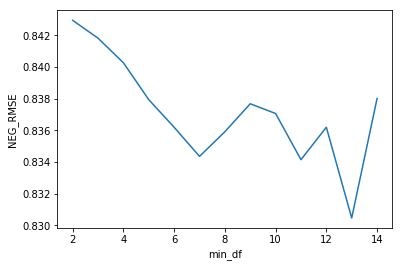

In [18]:
# Cross validation to find the best parameters 
range_for = range(2, 15, 1)
RMSE_scores_featu = []

for param in range_for:
    YearBinaryEnco = ce.BinaryEncoder()
    tfidf_plot = TfidfVectorizer(ngram_range=(1, (4+param)), max_features=7000+(param*500),  min_df=12+param)
    tfidf_title = TfidfVectorizer(ngram_range=(1, (4+param)), max_features=7000+(param*500), min_df=param)
    
    X_features = create_XFeatures(plot_clean, title_clean, dataTraining[["year"]], dataTraining.index, False, True)
    print(X_features.shape)
    X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_features, y_genres, test_size=0.33, random_state=42)
    
    clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=600, max_features=14, max_depth=20,  random_state=42))
    RMSE_scores_featu.append(cross_val_score(clf, X_train, y_train_genres, cv=3, scoring='roc_auc').mean())

best_param = range_for[RMSE_scores_featu.index(max(RMSE_scores_featu))]
print ("best_param: ", best_param)
plt.plot(range_for, RMSE_scores_featu)
plt.xlabel('min_df')
plt.ylabel('NEG_RMSE')



In [19]:
YearBinaryEnco = ce.BinaryEncoder()
tfidf_plot = TfidfVectorizer(ngram_range=(1, (4+best_param)), max_features=7000+(best_param*500),  min_df=12+best_param)
tfidf_title = TfidfVectorizer(ngram_range=(1, (4+best_param)), max_features=7000+(best_param*500), min_df=best_param)
vect_plot = CountVectorizer(ngram_range=(1, 4), max_features=7000,  min_df=12)
vect_title = CountVectorizer(ngram_range=(1, 4), max_features=7000,  min_df=2)

X_features = create_XFeatures(plot_clean, title_clean, dataTraining[["year"]], dataTraining.index, True, True)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_features, y_genres, test_size=0.33, random_state=42)


YearBinary: (7895, 8)
plot_tfidf_dtm: (7895, 4642)
title_tfidf_dtm: (7895, 4359)
plot_dtm: (7895, 5297)
title_dtm: (7895, 4310)


### Train multi-class multi-label model Random Forest

best_maxdepth:  14


Text(0, 0.5, 'NEG_RMSE')

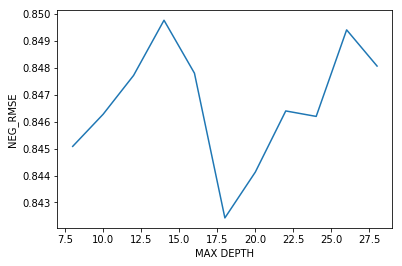

In [20]:
# Cross validation to find the best depth parameter 
max_depth_range = range(8, 30, 2)
RMSE_scores_featu = []

for depth in max_depth_range:
    clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=600, max_features=14, max_depth=depth,  random_state=17))
    RMSE_scores_featu.append(cross_val_score(clf, X_train, y_train_genres, cv=3, scoring='roc_auc').mean())

best_maxdepth = max_depth_range[RMSE_scores_featu.index(max(RMSE_scores_featu))]
print ("best_maxdepth: ", best_maxdepth)
plt.plot(max_depth_range, RMSE_scores_featu)
plt.xlabel('MAX DEPTH')
plt.ylabel('NEG_RMSE')

best_max_features:  16


Text(0, 0.5, 'NEG_RMSE')

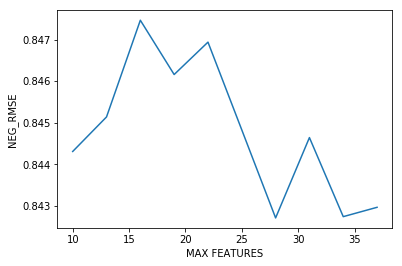

In [27]:
# Cross validation to find the best max_features
max_features_range = range(10, 40, 3)
RMSE_scores_featu = []

for features in max_features_range:
    clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=600, max_features=features, max_depth=best_maxdepth,  random_state=17))
    RMSE_scores_featu.append(cross_val_score(clf, X_train, y_train_genres, cv=3, scoring='roc_auc').mean())

best_max_features = max_features_range[RMSE_scores_featu.index(max(RMSE_scores_featu))]
print ("best_max_features: ", best_max_features)
plt.plot(max_features_range, RMSE_scores_featu)
plt.xlabel('MAX FEATURES')
plt.ylabel('NEG_RMSE')

best_n_estimators:  22


Text(0, 0.5, 'NEG_RMSE')

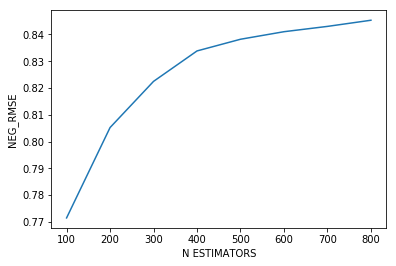

In [22]:
# Cross validation to find the best n_estimators
max_n_estimators = range(100, 900, 100)
RMSE_scores_featu = []

for estimators in max_n_estimators:
    clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=estimators, max_features=best_max_features, max_depth=best_maxdepth,  random_state=17))
    RMSE_scores_featu.append(cross_val_score(clf, X_train, y_train_genres, cv=3, scoring='roc_auc').mean())

best_n_estimators = max_depth_range[RMSE_scores_featu.index(max(RMSE_scores_featu))]
print ("best_n_estimators: ", best_n_estimators)
plt.plot(max_n_estimators, RMSE_scores_featu)
plt.xlabel('N ESTIMATORS')
plt.ylabel('NEG_RMSE')